In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel
from inference.frequentist.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 1],
            "activation": "tanh",
            "dim_reduction": False,
            "inference": "q_regr",
            "lr": 0.03,
            "num_iterations": 1000,
            "quantiles": [0.5],
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Quantile Regression

In [5]:
QR_torch_model = TorchModel(config.model_widths, config.activation, config.quantiles).to(device)

In [6]:
predictive, diagnostics = inference(config, QR_torch_model, None, X_train=train_embedding, Y_train=Ytr, X_test=test_embedding, Y_test=Yte, num_samples=None)

[iteration 0001] loss: 0.425580
[iteration 0101] loss: 0.421084
[iteration 0201] loss: 0.421082
[iteration 0301] loss: 0.421081
[iteration 0401] loss: 0.421081
[iteration 0501] loss: 0.421081
[iteration 0601] loss: 0.421081
[iteration 0701] loss: 0.421081
[iteration 0801] loss: 0.421081
[iteration 0901] loss: 0.421082


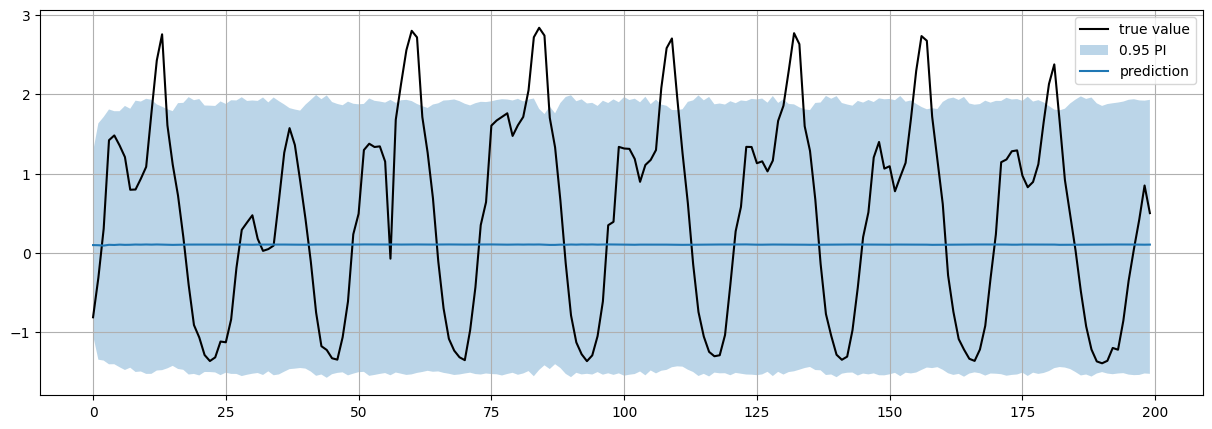

In [9]:
plot_forecast(predictive, Yte)

In [7]:
import matplotlib.pyplot as plt

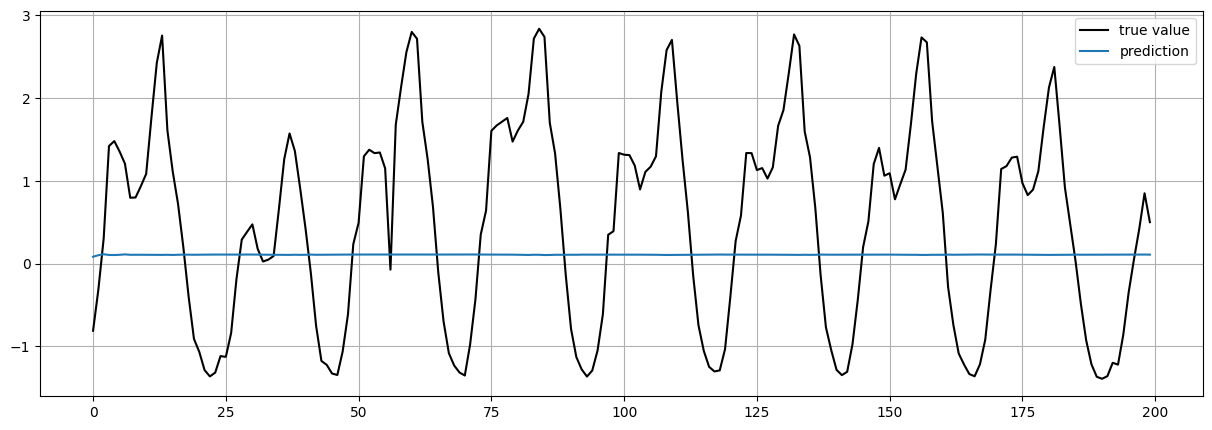

In [8]:

Y = Yte
fig = plt.figure(figsize=(15,5))
plt.plot(Y.cpu()[:200], label='true value', color='k')
plt.plot(predictive.cpu()[:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()

testing

https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb

More testing

In [11]:
class TestModel(torch.nn.Module):
    """
    Deterministic model

    :param list widths: List of layers' widths.
    :param string activation: String specifying the activation function to use.
    """
    def __init__(self, widths):
        super().__init__()
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(widths[0], widths[1]),
                # torch.nn.Tanh(),
                # torch.nn.Linear(widths[1], widths[2]),
            ]
        )

    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

In [12]:
model2 = TestModel([50, 1]).to(device)

In [16]:
loss = torch.nn.MSELoss()

epochs = 1000

model2.train()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.03, weight_decay=1e-2)

x = train_embedding
y = Ytr.unsqueeze(dim=-1)

In [17]:

for epoch in range(epochs):
    optimizer.zero_grad()
    # for data, y in zip(train_embedding, Ytr):
    pred = model2(x)
    l = loss(pred, y)
    l.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (epoch + 1, l / Ytr.shape[0]))

[iteration 0001] loss: 0.0002
[iteration 0101] loss: 0.0000
[iteration 0201] loss: 0.0000
[iteration 0301] loss: 0.0000
[iteration 0401] loss: 0.0000
[iteration 0501] loss: 0.0000
[iteration 0601] loss: 0.0000
[iteration 0701] loss: 0.0000
[iteration 0801] loss: 0.0000
[iteration 0901] loss: 0.0000


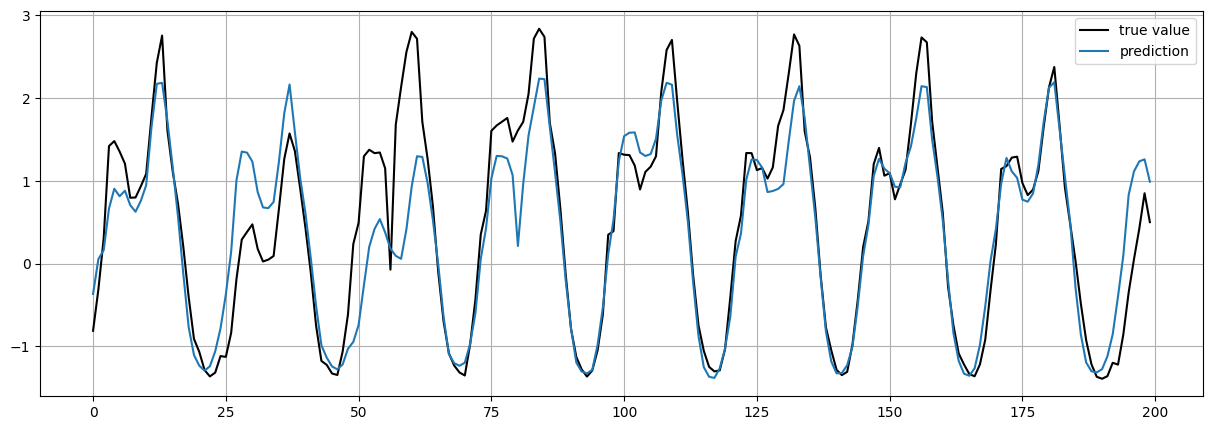

In [18]:
pred = model2(test_embedding)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[0:200].cpu(), label='true value', color='k')
plt.plot(pred.detach().cpu().numpy()[0:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

Maybe use https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html